# AMBER Epigenetics Tutorial

> Notebook Meta info:
>
> updated: November 16, 2020
>
> Last updated, March 22, 2021: better handling of Keras version
>
> Authors: Frank Zijun Zhang
> 
> Reference: Zhang, Zijun, et al. ["An automated framework for efficiently designing deep convolutional neural networks in genomics."](https://www.nature.com/articles/s42256-021-00316-z) Nature Machine Intelligence (2021): 1-9.
>
> [Preprint](https://www.biorxiv.org/content/10.1101/2020.08.18.251561v1)

In this notebook, we will run AMBER architecture search to design a Convolution Neural Network (CNN) that predicts 919 epigenetics markers in a 1000-bp DNA sequence input



## 1. Setup and Downloads


In [ ]:
%tensorflow_version 1.x
!python -m pip install -q amber-automl
!python -m pip install -q keras==2.2.5
import tensorflow as tf
! if [ ! -d deepsea_train ]; then wget http://deepsea.princeton.edu/media/code/deepsea_train_bundle.v0.9.tar.gz; tar -xvzf deepsea_train_bundle.v0.9.tar.gz; rm deepsea_train_bundle.v0.9.tar.gz; else echo "Found previous downloaded data."; fi

TensorFlow 1.x selected.
     |████████████████████████████████| 184kB 18.7MB/s 
     |████████████████████████████████| 337kB 40.7MB/s 
--2021-03-22 16:40:18--  http://deepsea.princeton.edu/media/code/deepsea_train_bundle.v0.9.tar.gz
Resolving deepsea.princeton.edu (deepsea.princeton.edu)... 128.112.117.108
Connecting to deepsea.princeton.edu (deepsea.princeton.edu)|128.112.117.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3821872019 (3.6G) [application/x-gzip]
Saving to: ‘deepsea_train_bundle.v0.9.tar.gz’

deepsea_train_bundl 100%[===================>]   3.56G  47.0MB/s    in 68s     

2021-03-22 16:41:25 (53.9 MB/s) - ‘deepsea_train_bundle.v0.9.tar.gz’ saved [3821872019/3821872019]

deepsea_train/
deepsea_train/train.mat
deepsea_train/test.mat
deepsea_train/4_train.lua
deepsea_train/run.sh
deepsea_train/1_data.lua
deepsea_train/3_loss.lua
deepsea_train/main.lua
deepsea_train/2_model.lua
deepsea_train/valid.mat
deepsea_train/LICENSE
deepsea_train/README

In [ ]:
try:
  import amber
  print('AMBER imported successfully')
except ModuleNotFoundError as e:
  print('You need to restart your colab runtime for AMBER to take effect.')
  print('Go to Runtime-->Restart Runtime and run all')
  raise e

Using TensorFlow backend.


AMBER imported successfully


##2. Define the Model Search Space

Users can freely define their own model space, by parsing different `amber.architect.Operation`.

Check the supported list of `Operation` here: https://amber-automl.readthedocs.io/en/latest/amber.architect.html#amber.architect.model_space.State

To fit the runtime of Google colab, this model space has been simplified.

In [ ]:
# Import everything we will need at top
import os
import shutil
# If you have trouble at this line AFTER installing AMBER, try
# restarting your colab runtime.
try:
  from amber import Amber
  from amber.architect import ModelSpace, Operation
except ModuleNotFoundError:
  print('Restart your Colab runtime by Runtime->restart runtime, and run this cell again')  

In [ ]:
def get_model_space(out_filters=64, num_layers=9, num_pool=3):
    model_space = ModelSpace()
    expand_layers = [num_layers//num_pool*i-1 for i in range(num_pool)]
    for i in range(num_layers):
        model_space.add_layer(i, [
            Operation('conv1d', filters=out_filters, kernel_size=8, activation='relu'),
            Operation('conv1d', filters=out_filters, kernel_size=4, activation='relu'),
            Operation('maxpool1d', filters=out_filters, pool_size=4, strides=1),
            Operation('avgpool1d', filters=out_filters, pool_size=4, strides=1),
            Operation('identity', filters=out_filters),
      ])
        if i in expand_layers:
            out_filters *= 2
    return model_space

In [ ]:
# define data loaders
import h5py
from scipy.io import loadmat
import numpy as np
import pandas as pd


def read_train_data(fp=None):
    fp = fp or "./deepsea_train/train.mat"
    f = h5py.File(fp, "r")
    print(list(f.keys()))
    y = f['traindata'].value
    x = f['trainxdata'].value
    x = np.moveaxis(x, -1, 0)
    y = np.moveaxis(y, -1, 0)
    return x, y


def read_val_data(fp=None):
    fp = fp or "./deepsea_train/valid.mat"
    f = loadmat(fp)
    print(list(f.keys()))
    x = f['validxdata']
    y = f['validdata']
    x = np.moveaxis(x, 1, -1)
    return x, y


def read_test_data(fp=None):
    fp = fp or "./deepsea_train/test.mat"
    f = loadmat(fp)
    print(list(f.keys()))
    x = f['testxdata']
    y = f['testdata']
    x = np.moveaxis(x, 1, -1)
    return x, y

# load the data - will take a while
# Not enough RAM in the free-tier Google Colab
#train_data = read_train_data()  

val_data = read_val_data()
# As poor man's version, use test data as train data. For the purpose
# of running AMBER, it will go through; however, the user should use the actuall
# train data, if resouces permit.
train_data = read_test_data()

['__header__', '__version__', '__globals__', 'validdata', 'validxdata']
['__header__', '__version__', '__globals__', 'testdata', 'testxdata']


##3. Define AMBER components and specifications

In [ ]:
# First, define the components we need to use
type_dict = {
    'controller_type': 'GeneralController',
    'modeler_type': 'EnasCnnModelBuilder',
    'knowledge_fn_type': 'zero',
    'reward_fn_type': 'LossAucReward',
    'manager_type': 'EnasManager',
    'env_type': 'EnasTrainEnv'
}


# Next, define the specifics
wd = "./outputs/AmberDeepSea/"
if os.path.isdir(wd):
  shutil.rmtree(wd)
os.makedirs(wd)
input_node = Operation('input', shape=(1000, 4), name="input")
output_node = Operation('dense', units=919, activation='sigmoid')
model_compile_dict = {
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
}

model_space = get_model_space(out_filters=8, num_layers=6)

specs = {
    'model_space': model_space,
    
    'controller': {
            'share_embedding': {i:0 for i in range(1, len(model_space))},
            'with_skip_connection': True,
            'skip_weight': 1.0,
            'skip_target': 0.4,
            'kl_threshold': 0.01,
            'train_pi_iter': 10,
            'buffer_size': 1,  
            'batch_size': 20
    },

    'model_builder': {
        'dag_func': 'EnasConv1dDAG',
        'batch_size': 512,
        'inputs_op': [input_node],
        'outputs_op': [output_node],
        'model_compile_dict': model_compile_dict,
         'dag_kwargs': {
            'stem_config': {
                'flatten_op': 'flatten',
                'fc_units': 100
            }
        }
    },

    'knowledge_fn': {'data': None, 'params': {}},

    'reward_fn': {'method': 'auc'},

    'manager': {
        'data': {
            'train_data': train_data,
            'validation_data': val_data
        },
        'params': {
            'epochs': 1,
            'child_batchsize': 512,
            'store_fn': 'minimal',
            'working_dir': wd,
            'verbose': 2
        }
    },

    'train_env': {
        'max_episode': 20,            # has been reduced for running in colab
        'max_step_per_ep': 20,       # has been reduced for running in colab
        'working_dir': wd,
        'time_budget': "00:15:00",    # has been reduced for running in colab
        'with_input_blocks': False,  
        'with_skip_connection': True,
        'child_train_steps': 20,      # has been reduced for running in colab
    }
}



##4. Run AMBER search

In [ ]:
# finally, run program
amb = Amber(types=type_dict, specs=specs)
# you can do some checking/debugging before run
# for example, this returns the controller instance:
amb.controller

BUILDING
----------
controller = GeneralController
modeler = EnasCnnModelBuilder
knowledge = zero
reward = LossAucReward
manager = EnasManager
time budget set to: 00:15:00
env_type = EnasTrainEnv


In [ ]:
amb.run()

 Trial 0: Start training model with sample_arc...
16:43:55 0/20, loss=0.94786
Epoch 0, loss=0.6932
Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 0.020395589992403984 KL(old || new): 8.067921442034276e-09 Entropy(new) = 0.596768319606781
     Epoch: 2 Actor Loss: 0.020375467215975124 KL(old || new): 7.94377719159911e-09 Entropy(new) = 0.5967671275138855
     Epoch: 4 Actor Loss: 0.02035343125462532 KL(old || new): 1.511158664868617e-08 Entropy(new) = 0.5967654585838318
     Epoch: 6 Actor Loss: 0.020328901708126068 KL(old || new): 2.6939586561525175e-08 Entropy(new) = 0.5967631936073303
     Epoch: 8 Actor Loss: 0.020301078342729144 KL(old || new): 4.182830792842651e-08 Entropy(new) = 0.5967603325843811


2021-03-22 16:45:06,962 - AMBER - INFO -
 Total reward : 1.1102230246251565e-16
2021-03-22 16:45:06,963 - AMBER - INFO -
 END episode 0: Controller loss : 0.020286
2021-03-22 16:45:06,964 - AMBER - INFO -
 ----------
2021-03-22 16:45:06,969 - AMBER - INFO -
 used time: 9.24 %


 Trial 1: Start training model with sample_arc...
16:45:10 0/20, loss=0.49578
Epoch 0, loss=0.3691
Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 11.191683769226074 KL(old || new): 6.647432826412114e-09 Entropy(new) = 0.5967839956283569
     Epoch: 2 Actor Loss: 11.191554387410482 KL(old || new): 8.386283667505268e-09 Entropy(new) = 0.596782922744751
     Epoch: 4 Actor Loss: 11.191389274597167 KL(old || new): 4.0466744621880935e-08 Entropy(new) = 0.5967808365821838
     Epoch: 6 Actor Loss: 11.19119303567069 KL(old || new): 9.507824927368347e-08 Entropy(new) = 0.596778392791748


2021-03-22 16:46:16,835 - AMBER - INFO -
 Total reward : 0.5570539541409747
2021-03-22 16:46:16,836 - AMBER - INFO -
 END episode 1: Controller loss : 11.190827
2021-03-22 16:46:16,838 - AMBER - INFO -
 ----------
2021-03-22 16:46:16,840 - AMBER - INFO -
 used time: 17.00 %


     Epoch: 8 Actor Loss: 11.190960460238987 KL(old || new): 2.0613627782495314e-07 Entropy(new) = 0.5967757105827332
 Trial 2: Start training model with sample_arc...
16:46:17 0/20, loss=0.22843
Epoch 0, loss=0.1775
Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 1.2407697439193726 KL(old || new): 1.0848607345792516e-08 Entropy(new) = 0.5967177152633667
     Epoch: 2 Actor Loss: 1.240382154782613 KL(old || new): 1.3582577196302736e-07 Entropy(new) = 0.5966933965682983
     Epoch: 4 Actor Loss: 1.2398540735244752 KL(old || new): 5.93075981214497e-07 Entropy(new) = 0.5966601371765137
     Epoch: 6 Actor Loss: 1.239140169961112 KL(old || new): 1.9021762227566796e-06 Entropy(new) = 0.5966129302978516


2021-03-22 16:47:18,600 - AMBER - INFO -
 Total reward : 0.6179398496835307
2021-03-22 16:47:18,601 - AMBER - INFO -
 END episode 2: Controller loss : 1.237552
2021-03-22 16:47:18,603 - AMBER - INFO -
 ----------
2021-03-22 16:47:18,606 - AMBER - INFO -
 used time: 23.86 %


     Epoch: 8 Actor Loss: 1.238167444864909 KL(old || new): 5.37207370143733e-06 Entropy(new) = 0.5965439081192017
 Trial 3: Start training model with sample_arc...
16:47:18 0/20, loss=0.14765
Epoch 0, loss=0.1333
Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 2.994953155517578 KL(old || new): 4.072142871791584e-07 Entropy(new) = 0.5965463519096375
     Epoch: 2 Actor Loss: 2.9941508769989014 KL(old || new): 4.701451416622149e-06 Entropy(new) = 0.5964652299880981
     Epoch: 4 Actor Loss: 2.9930514812469484 KL(old || new): 1.7438773284084164e-05 Entropy(new) = 0.5963671803474426
     Epoch: 6 Actor Loss: 2.991565159388951 KL(old || new): 4.8257272283080965e-05 Entropy(new) = 0.596243679523468


2021-03-22 16:48:21,062 - AMBER - INFO -
 Total reward : 0.7663622095143121
2021-03-22 16:48:21,063 - AMBER - INFO -
 END episode 3: Controller loss : 2.988271
2021-03-22 16:48:21,065 - AMBER - INFO -
 ----------
2021-03-22 16:48:21,068 - AMBER - INFO -
 used time: 30.80 %


     Epoch: 8 Actor Loss: 2.989545848634508 KL(old || new): 0.00012014676758553833 Entropy(new) = 0.596085786819458
 Trial 4: Start training model with sample_arc...
16:48:21 0/20, loss=0.12902
Epoch 0, loss=0.1147
Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: -0.889831006526947 KL(old || new): 6.9829943640797865e-06 Entropy(new) = 0.597650945186615
     Epoch: 2 Actor Loss: -0.8930241068204244 KL(old || new): 7.23299672245048e-05 Entropy(new) = 0.5979706048965454
     Epoch: 4 Actor Loss: -0.8976263165473938 KL(old || new): 0.0002557714469730854 Entropy(new) = 0.5984277129173279
     Epoch: 6 Actor Loss: -0.904089902128492 KL(old || new): 0.0007109931320883334 Entropy(new) = 0.5992207527160645


2021-03-22 16:49:25,390 - AMBER - INFO -
 Total reward : 0.7212869000717526
2021-03-22 16:49:25,391 - AMBER - INFO -
 END episode 4: Controller loss : -0.919325
2021-03-22 16:49:25,393 - AMBER - INFO -
 ----------
2021-03-22 16:49:25,395 - AMBER - INFO -
 used time: 37.95 %


     Epoch: 8 Actor Loss: -0.91326947344674 KL(old || new): 0.001840261509642005 Entropy(new) = 0.6007770299911499
 Trial 5: Start training model with sample_arc...
16:49:25 0/20, loss=0.11247
Epoch 0, loss=0.1098


2021-03-22 16:50:29,241 - AMBER - INFO -
 Total reward : 0.9779182348195783
2021-03-22 16:50:29,242 - AMBER - INFO -
 END episode 5: Controller loss : 5.036561
2021-03-22 16:50:29,243 - AMBER - INFO -
 ----------
2021-03-22 16:50:29,249 - AMBER - INFO -
 used time: 45.05 %


Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 5.073516845703125 KL(old || new): 0.00016581804084125906 Entropy(new) = 0.5984064340591431
     Epoch: 2 Actor Loss: 5.057442347208659 KL(old || new): 0.0023770073894411325 Entropy(new) = 0.6024836897850037
     Early stopping at step 5 as KL(old || new) =  0.010025950148701668
 Trial 6: Start training model with sample_arc...
16:50:29 0/20, loss=0.11411
Epoch 0, loss=0.1090


2021-03-22 16:51:32,967 - AMBER - INFO -
 Total reward : 1.4120330723332326
2021-03-22 16:51:32,968 - AMBER - INFO -
 END episode 6: Controller loss : 8.117171
2021-03-22 16:51:32,969 - AMBER - INFO -
 ----------
2021-03-22 16:51:32,974 - AMBER - INFO -
 used time: 52.13 %


Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 8.122179985046387 KL(old || new): 0.0011755857849493623 Entropy(new) = 0.5919966697692871
     Early stopping at step 3 as KL(old || new) =  0.013892279006540775
 Trial 7: Start training model with sample_arc...
16:51:33 0/20, loss=0.11212
Epoch 0, loss=0.1061


2021-03-22 16:52:37,418 - AMBER - INFO -
 Total reward : 1.4545080858541097
2021-03-22 16:52:37,419 - AMBER - INFO -
 END episode 7: Controller loss : 1.127752
2021-03-22 16:52:37,420 - AMBER - INFO -
 ----------
2021-03-22 16:52:37,422 - AMBER - INFO -
 used time: 59.29 %


Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 1.2120829820632935 KL(old || new): 5.319923729985021e-05 Entropy(new) = 0.5377776622772217
     Epoch: 2 Actor Loss: 1.1854878664016724 KL(old || new): 0.000865649722982198 Entropy(new) = 0.5382351279258728
     Epoch: 4 Actor Loss: 1.1475085735321044 KL(old || new): 0.006906357128173113 Entropy(new) = 0.5429178476333618
     Early stopping at step 6 as KL(old || new) =  0.012052580714225769
 Trial 8: Start training model with sample_arc...
16:52:37 0/20, loss=0.10962
Epoch 0, loss=0.1044


2021-03-22 16:53:40,818 - AMBER - INFO -
 Total reward : 1.4783301569670153
2021-03-22 16:53:40,818 - AMBER - INFO -
 END episode 8: Controller loss : 0.482058
2021-03-22 16:53:40,819 - AMBER - INFO -
 ----------
2021-03-22 16:53:40,825 - AMBER - INFO -
 used time: 66.33 %


Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 0.5289958119392395 KL(old || new): 0.0008062184788286686 Entropy(new) = 0.5695553421974182
     Epoch: 2 Actor Loss: 0.4995911816755931 KL(old || new): 0.005656122229993343 Entropy(new) = 0.5739230513572693
     Early stopping at step 5 as KL(old || new) =  0.011467263102531433
 Trial 9: Start training model with sample_arc...
16:53:41 0/20, loss=0.11375
Epoch 0, loss=0.1002
Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 6.757843017578125 KL(old || new): 4.331585660111159e-05 Entropy(new) = 0.5893366932868958
     Epoch: 2 Actor Loss: 6.762408256530762 KL(old || new): 6.580763874808326e-05 Entropy(new) = 0.5894820690155029
     Epoch: 4 Actor Loss: 6.7499086380004885 KL(old || new): 2.7327501811669208e-05 Entropy(new) = 0.589184582233429
     Epoch: 6 Actor Loss: 6.721451554979597 KL(old || new): 0.0006817876710556448 Entropy(new) = 0.5889785289764404


2021-03-22 16:54:44,616 - AMBER - INFO -
 Total reward : 1.8335138531087218
2021-03-22 16:54:44,616 - AMBER - INFO -
 END episode 9: Controller loss : 6.646035
2021-03-22 16:54:44,618 - AMBER - INFO -
 ----------
2021-03-22 16:54:44,619 - AMBER - INFO -
 used time: 73.42 %


     Epoch: 8 Actor Loss: 6.675828562842475 KL(old || new): 0.004321627784520388 Entropy(new) = 0.5903322100639343
 Trial 10: Start training model with sample_arc...
16:54:44 0/20, loss=0.09163
Epoch 0, loss=0.1000


2021-03-22 16:55:48,082 - AMBER - INFO -
 Total reward : 1.7604784833651839
2021-03-22 16:55:48,083 - AMBER - INFO -
 END episode 10: Controller loss : -1.559333
2021-03-22 16:55:48,085 - AMBER - INFO -
 ----------
2021-03-22 16:55:48,087 - AMBER - INFO -
 used time: 80.47 %


Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: -1.5528475046157837 KL(old || new): 0.0008356032776646316 Entropy(new) = 0.5863440036773682
     Epoch: 2 Actor Loss: -1.556127667427063 KL(old || new): 0.007669511716812849 Entropy(new) = 0.5935142040252686
     Early stopping at step 4 as KL(old || new) =  0.013256292790174484
 Trial 11: Start training model with sample_arc...
16:55:48 0/20, loss=0.09841
Epoch 0, loss=0.0955


2021-03-22 16:56:52,480 - AMBER - INFO -
 Total reward : 1.8718892002822467
2021-03-22 16:56:52,480 - AMBER - INFO -
 END episode 11: Controller loss : 1.698038
2021-03-22 16:56:52,481 - AMBER - INFO -
 ----------
2021-03-22 16:56:52,486 - AMBER - INFO -
 used time: 87.63 %


Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 1.7509541511535645 KL(old || new): 0.0009990319376811385 Entropy(new) = 0.5573147535324097
     Early stopping at step 3 as KL(old || new) =  0.012833341024816036
 Trial 12: Start training model with sample_arc...
16:56:52 0/20, loss=0.09298
Epoch 0, loss=0.0937


2021-03-22 16:57:56,548 - AMBER - INFO -
 Total reward : 1.4314962426779694
2021-03-22 16:57:56,548 - AMBER - INFO -
 END episode 12: Controller loss : -10.166151
2021-03-22 16:57:56,550 - AMBER - INFO -
 ----------
2021-03-22 16:57:56,552 - AMBER - INFO -
 used time: 94.75 %


Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: -9.93197250366211 KL(old || new): 0.003172137076035142 Entropy(new) = 0.5379088521003723
     Early stopping at step 2 as KL(old || new) =  0.01624981500208378
 Trial 13: Start training model with sample_arc...
16:57:56 0/20, loss=0.09195
Epoch 0, loss=0.0928


2021-03-22 16:59:00,693 - AMBER - INFO -
 Total reward : 1.8385066897988789
2021-03-22 16:59:00,694 - AMBER - INFO -
 END episode 13: Controller loss : 6.634586
2021-03-22 16:59:00,694 - AMBER - INFO -
 ----------
2021-03-22 16:59:00,697 - AMBER - INFO -
 used time: 101.87 %
2021-03-22 16:59:00,699 - AMBER - INFO -
 training ceased because run out of time budget
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Saved buffers to file `buffers.txt` !
     Epoch: 0 Actor Loss: 6.561089992523193 KL(old || new): 0.003027091035619378 Entropy(new) = 0.4677990674972534
     Early stopping at step 3 as KL(old || new) =  0.012144551612436771


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


##5. Get the best architecture and re-train from scratch

In [ ]:
from amber.utils.io import read_history
hist = read_history([os.path.join(wd, "train_history.csv")], 
                    metric_name_dict={'zero':0, 'auc': 1})
hist = hist.sort_values(by='auc', ascending=False)
hist.head(n=5)

read 1 history files, total 280 lines 


,ID,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,dir,zero,auc
196,196,1,1,1,2,1,0,0,1,0,0,2,1,0,1,1,4,1,1,1,1,1,./outputs/AmberDeepSea,0.0,0.649112
255,255,1,2,1,1,0,0,3,1,0,1,1,1,1,1,0,1,1,0,1,1,1,./outputs/AmberDeepSea,0.0,0.647887
233,233,1,4,0,0,1,0,1,1,1,1,4,1,0,0,1,0,1,1,1,1,1,./outputs/AmberDeepSea,0.0,0.646986
213,213,1,1,1,0,1,1,2,1,0,1,2,1,1,0,0,1,0,1,1,1,0,./outputs/AmberDeepSea,0.0,0.645316
175,175,3,0,0,0,1,0,3,1,1,1,1,0,1,1,0,2,1,1,1,1,0,./outputs/AmberDeepSea,0.0,0.644386


In [ ]:
from amber.modeler import KerasResidualCnnBuilder

keras_builder = KerasResidualCnnBuilder(
    inputs_op=input_node,
    output_op=output_node,
    fc_units=100,
    flatten_mode='Flatten',
    model_compile_dict={
        'loss': 'binary_crossentropy',
        'optimizer': 'adam',
        'metrics': ['acc']
        },
    model_space=model_space,
    dropout_rate=0.1,
    wsf=2
)

best_arc = hist.iloc[0][[x for x in hist.columns if x.startswith('L')]].tolist()
searched_mod = keras_builder(best_arc)

[8, 8, 16, 16, 32, 32]
[1, 3]
start_idx=0, layer id=0, out_filters=8 x 2
conv1d:{'filters': 8, 'kernel_size': 4, 'activation': 'relu'}
--------------------------------------------------------------------------------
start_idx=1, layer id=1, out_filters=8 x 2
conv1d:{'filters': 8, 'kernel_size': 4, 'activation': 'relu'}
skip=[1]
pooled@1, [<tf.Tensor 'max_pooling1d_24/Squeeze:0' shape=(?, 250, 32) dtype=float32>, <tf.Tensor 'max_pooling1d_25/Squeeze:0' shape=(?, 250, 32) dtype=float32>]
--------------------------------------------------------------------------------
start_idx=3, layer id=2, out_filters=16 x 2
maxpool1d:{'filters': 16, 'pool_size': 4, 'strides': 1}
skip=[1, 0]
--------------------------------------------------------------------------------
start_idx=6, layer id=3, out_filters=16 x 2
conv1d:{'filters': 16, 'kernel_size': 8, 'activation': 'relu'}
skip=[1, 0, 0]
pooled@3, [<tf.Tensor 'max_pooling1d_26/Squeeze:0' shape=(?, 63, 64) dtype=float32>, <tf.Tensor 'max_pooling1d_27

In [ ]:
searched_mod.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
stem_conv_conv (Conv1D)         (None, 1000, 16)     512         input[0][0]                      
__________________________________________________________________________________________________
stem_conv_bn (BatchNormalizatio (None, 1000, 16)     64          stem_conv_conv[0][0]             
__________________________________________________________________________________________________
L0_conv (Conv1D)                (None, 1000, 16)     1024        stem_conv_bn[0][0]               
______________________________________________________________________________________________

In [ ]:
searched_mod.fit(
    train_data[0], 
    train_data[1],
    batch_size=1024,
    validation_data=val_data,
    epochs=5,
    verbose=1
)

Train on 455024 samples, validate on 8000 samples
Epoch 1/5
455024/455024 [==============================] - 138s 302us/sample - loss: 0.1002 - acc: 0.9729 - val_loss: 0.0863 - val_acc: 0.9798
Epoch 2/5
455024/455024 [==============================] - 134s 294us/sample - loss: 0.0795 - acc: 0.9799 - val_loss: 0.0885 - val_acc: 0.9766
Epoch 3/5
455024/455024 [==============================] - 133s 293us/sample - loss: 0.0779 - acc: 0.9800 - val_loss: 0.0965 - val_acc: 0.9719
Epoch 4/5
455024/455024 [==============================] - 133s 292us/sample - loss: 0.0766 - acc: 0.9800 - val_loss: 0.0904 - val_acc: 0.9755
Epoch 5/5
455024/455024 [==============================] - 133s 292us/sample - loss: 0.0751 - acc: 0.9800 - val_loss: 0.0907 - val_acc: 0.9736


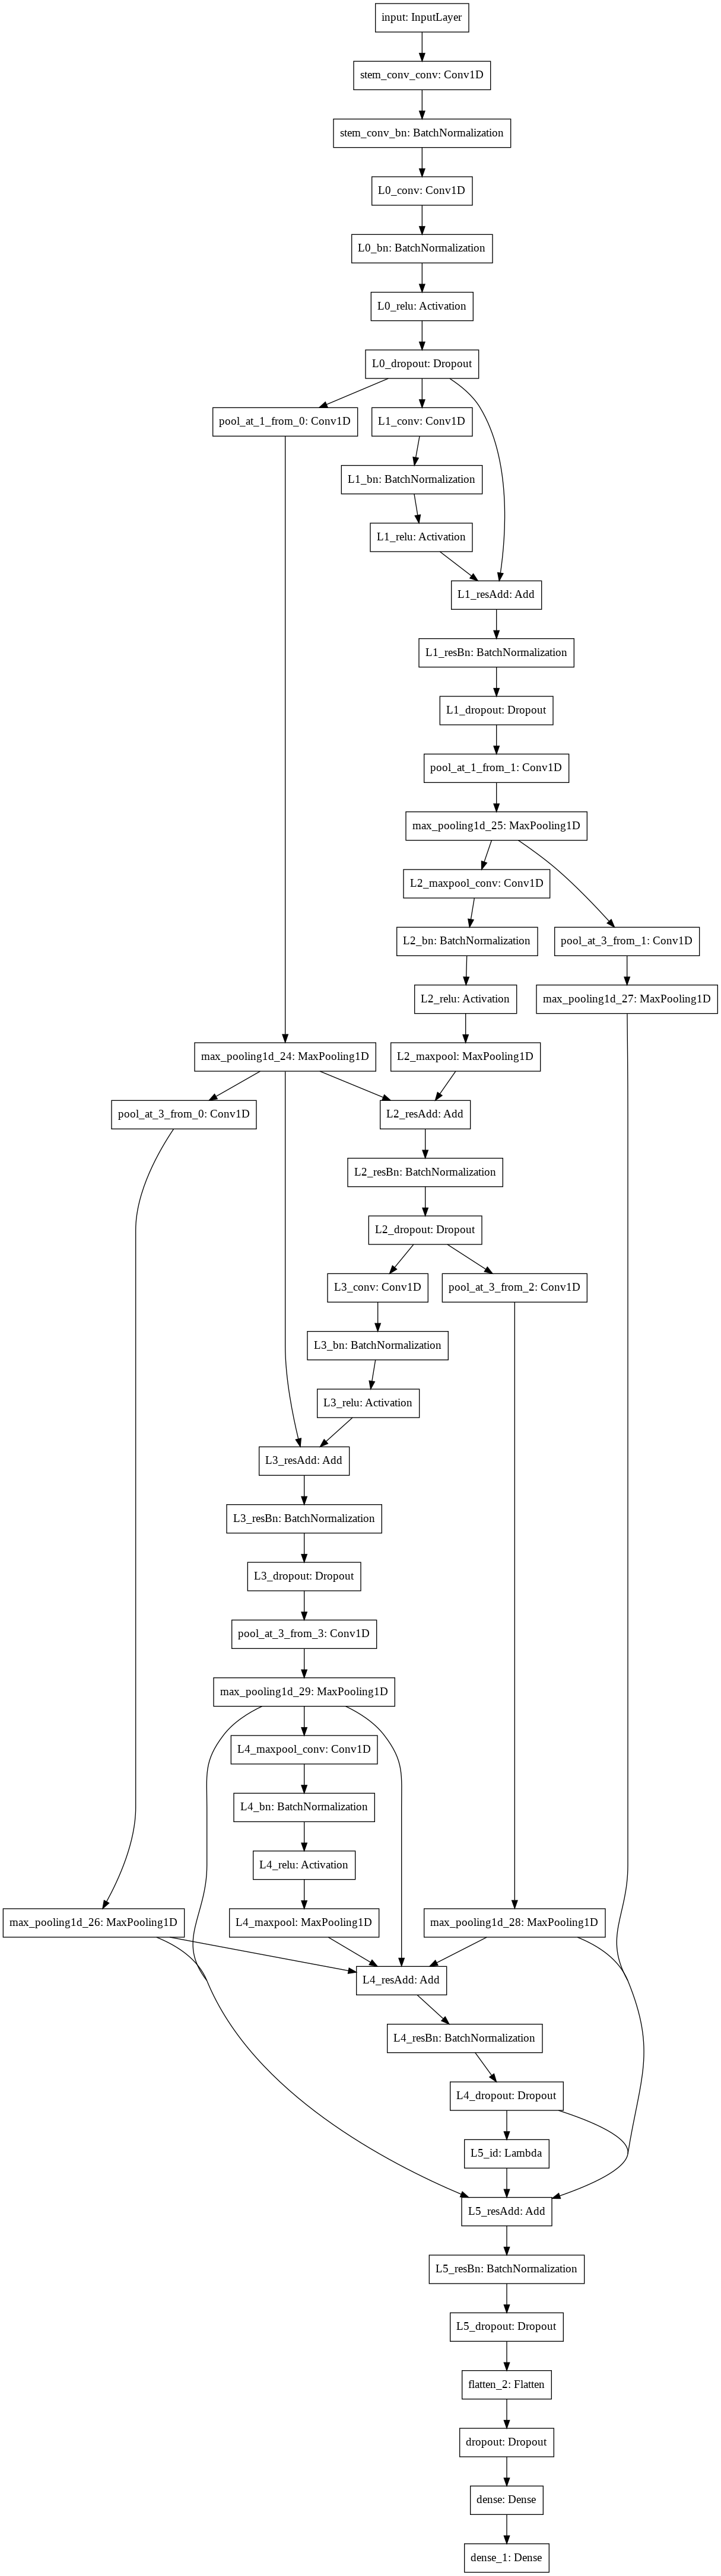

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(searched_mod, show_layer_names=True,
           to_file=os.path.join(wd, "model_arc.png")
           )
Image(filename=os.path.join(wd, 'model_arc.png'), height=1000)